In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from IPython import display
import seaborn as sns
sns.set()
import matplotlib
from pylab import rcParams
import itertools 
import time 
from random import seed
from random import random
from matplotlib import pyplot
# 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, auc
#from skimage.io import imread
from PIL import Image

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly.subplots import make_subplots

#Reading data, calendar and sell_prices
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')
train.head(3)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0


## Patient Id Counts

### Extract gender per patient

In [2]:
def create_patient_df(train,test):
    #Create a series with patient_id as index and gender values for train and test
    patient_gender_train = train.groupby("patient_id").sex.unique().apply(lambda l: l[0])
    patient_gender_test = test.groupby("patient_id").sex.unique().apply(lambda l: l[0])
    #Convert series into train_patients and test_patients dataframes 
    train_patients = pd.DataFrame(index=patient_gender_train.index.values, 
                                  data=patient_gender_train.values, columns=["sex"])
    test_patients = pd.DataFrame(index=patient_gender_test.index.values, 
                                 data=patient_gender_test.values, columns=["sex"])
    #Extract nun_images with proper groupby
    train_patients["num_images"] = train.groupby("patient_id").size()
    test_patients["num_images"] = test.groupby("patient_id").size()
    #Extract age_span for patient with multiple images
    train_patients["min_age"] = train.groupby("patient_id").age_approx.min()
    train_patients["max_age"] = train.groupby("patient_id").age_approx.max()
    test_patients["min_age"] = test.groupby("patient_id").age_approx.min()
    test_patients["max_age"] = test.groupby("patient_id").age_approx.max()
    train_patients["age_span"] = train_patients["max_age"] - train_patients["min_age"]
    test_patients["age_span"] = test_patients["max_age"] - test_patients["min_age"]
    #Extract benign_cases  and min and max aged for malignant
    train_patients["benign_cases"] = train.groupby(["patient_id", "benign_malignant"]).size().loc[:, "benign"]
    train_patients["malignant_cases"] = train.groupby(["patient_id", "benign_malignant"]).size().loc[:, "malignant"]
    train_patients["min_age_malignant"] = train.groupby(["patient_id", "benign_malignant"]).age_approx.min().loc[:, "malignant"]
    train_patients["max_age_malignant"] = train.groupby(["patient_id", "benign_malignant"]).age_approx.max().loc[:, "malignant"]
    return train_patients, test_patients
train_patients, test_patients = create_patient_df(train,test)

In [3]:
print("train_patients shape:",train_patients.shape)
print('Malignant cases count train:')
print(train_patients.malignant_cases.notnull().value_counts())
train_patients.sort_values(by="malignant_cases", ascending=False).head()

train_patients shape: (2056, 9)
Malignant cases count train:
False    1628
True      428
Name: malignant_cases, dtype: int64


,sex,num_images,min_age,max_age,age_span,benign_cases,malignant_cases,min_age_malignant,max_age_malignant
IP_7373371,female,42,55.0,60.0,5.0,34.0,8.0,55.0,60.0
IP_9111321,male,13,60.0,60.0,0.0,7.0,6.0,60.0,60.0
IP_2412574,male,23,65.0,70.0,5.0,18.0,5.0,65.0,70.0
IP_3237442,male,8,65.0,85.0,20.0,3.0,5.0,65.0,80.0
IP_9037179,male,7,70.0,75.0,5.0,3.0,4.0,70.0,70.0


### Categorical variables

### Preprocess categorical variables 
The `anatom_site_general_challenge` in the train set has a lot of  NaNs, we will repalce them with the `.mode()`. For the `sex` category we only have a small number of NaNs and only two categories, for that reason we will replace it with the mode. Is this the best approach ??

In [261]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
# target
cols_to_drop = ['image_name','diagnosis', 'benign_malignant','target']
y = train.target
X = train.drop(cols_to_drop, axis=1)

#Missing values Categorcial values
# Fill NaN with Unknown on anatom_site_general_challenge
mode1 = X['anatom_site_general_challenge'].mode()[0]
X['anatom_site_general_challenge'].fillna('Unknown', inplace=True)
# Fill NaN with mode on 'sex'
mode = X['sex'].mode()[0]
X['sex'].fillna('Unknown', inplace=True)

#Add patient df to train set
train_patients_cols_add=["num_images","min_age","max_age","age_span"]
X=X.set_index('patient_id').join(train_patients[train_patients_cols_add]).reset_index()
X = X.rename(columns={'index': 'patient_id'})
#Add patient test set
X_test=test.set_index('patient_id').join(test_patients[train_patients_cols_add]).reset_index()
X_test = X_test.rename(columns={'index': 'patient_id'})


# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=42)
# All categorical columns
object_cols = ['patient_id', 'sex', 'anatom_site_general_challenge']

# Imputation Numerical features 
# Get names of columns with missing values
cols_with_missing = ['age_approx', 'min_age','max_age','age_span']
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train[cols_with_missing]), index=X_train.index)
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid[cols_with_missing]), index=X_valid.index)

# Imputation removed column names; put them back
imputed_X_train.columns = X_train[cols_with_missing].columns
imputed_X_valid.columns = X_valid[cols_with_missing].columns


# Label encode
# Columns that can be safely label encoded and Problematic columns
label_cols = ['sex', 'anatom_site_general_challenge']
not_label_cols = ['patient_id', 'age_approx', 'min_age','max_age','age_span','num_images']
# Drop categorical columns that will not be encoded
label_X_train = X_train.drop(not_label_cols, axis=1)
label_X_valid = X_valid.drop(not_label_cols, axis=1)
# Apply label encoder to bad_label_cols 
label_encoder = preprocessing.LabelEncoder()
for col in label_cols:
    label_X_train[col] = label_encoder.fit_transform(label_X_train[col])
    label_X_valid[col] = label_encoder.transform(label_X_valid[col])
    
X_train.head(1)

,patient_id,sex,age_approx,anatom_site_general_challenge,num_images,min_age,max_age,age_span
22826,IP_7121757,female,35.0,torso,54,35.0,35.0,0.0


In [148]:
imputed_X_train.head(1)

,age_approx,min_age,max_age,age_span
22826,35.0,35.0,35.0,0.0


In [146]:
label_X_train.head(1)

,sex,anatom_site_general_challenge
22826,0,4


# ToDo
1. Try OneHot
2. Feature Importance 
3. Pipelines
4. Prepare to join other data
4. Put into functions

### 1) Add interaction features

Add interaction features for each pair of categorical features (sex, anatom_site_general_challenge ). Iterate through the pairs of features is with `itertools.combinations`. For each new column, join the values as strings with an underscore, so 13 and 47 would become `"13_47"`. Label encode the values.

In [317]:
import itertools

cat_features = ['sex', 'anatom_site_general_challenge']
def create_interactions(train, valid, cat_features): 
    interactions_train = pd.DataFrame(index=train.index)
    interactions_valid = pd.DataFrame(index=valid.index)
    # Iterate through each pair of features, combine them into interaction features
    encoder = preprocessing.LabelEncoder()
    for col1, col2 in itertools.combinations(cat_features,2):
        new_col = col1 +'_'+ col2 
        new_vals = train[col1].map(str) + '_' + train[col2].map(str)
        interactions_train[new_col] = encoder.fit_transform(new_vals)
        new_vals = valid[col1].map(str) + '_' + valid[col2].map(str)
        interactions_valid[new_col] = encoder.transform(new_vals)
    return interactions_train, interactions_valid
interactions_train, interactions_valid = create_interactions(X_train,X_valid, cat_features) 
interactions_train.head(1)

,sex_anatom_site_general_challenge
22826,9


In [150]:
interactions_valid.head(1)

,sex_anatom_site_general_challenge
8231,4


## Generate Baseline data
### Random Forest model
#### Define AUC metric

In [325]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Function for comparing different approaches
def score_dataset_randomForest(X_train, X_valid, y_train, y_valid):
    model = RandomForestClassifier(n_estimators=10, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    fpr, tpr, _ = metrics.roc_curve(y_valid, preds, pos_label=None)
    plt.plot(fpr,tpr)
    plt.plot(fpr,fpr)
    plt.xlabel('false positives rate')
    plt.ylabel('true positives rate')
    return metrics.roc_auc_score(y_valid, preds)

1. Try all features

AUC from Approach 2 (Imputation):
0.5032795967626331


,num_images,age_approx,min_age,max_age,age_span,sex,anatom_site_general_challenge,sex_anatom_site_general_challenge
22826,54,35.0,35.0,35.0,0.0,1,5,9
20292,30,35.0,30.0,35.0,5.0,2,2,13
29431,26,45.0,45.0,45.0,0.0,2,1,12
15395,52,30.0,30.0,30.0,0.0,1,5,9
2333,58,80.0,80.0,80.0,0.0,2,5,16


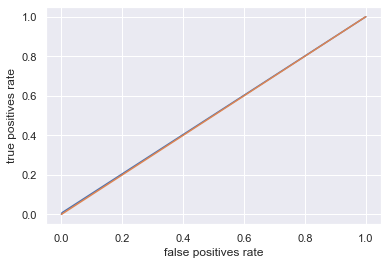

In [326]:
cols_to_keep = ['num_images']
#add imputed
baseline_train = X_train[cols_to_keep].join(imputed_X_train)
baseline_valid = X_valid[cols_to_keep].join(imputed_X_valid)
#add categorical label
baseline_train = baseline_train.join(label_X_train)
baseline_valid = baseline_valid.join(label_X_valid)
#add interactions
baseline_train = baseline_train.join(interactions_train)
baseline_valid = baseline_valid.join(interactions_valid)

#baseline_train.drop(columns= cols_to_keep, inplace=True)
#baseline_valid.drop(columns=cols_to_keep, inplace=True)
print("AUC from Approach 2 (Imputation):")
cols_to_drop = ["min_age","max_age","sex"] 
print(score_dataset_randomForest(baseline_train.drop(columns=cols_to_drop), baseline_valid.drop(columns=cols_to_drop), y_train, y_valid))

baseline_train.head()

2. Try only imputed

AUC from Approach 2 (Imputation):
0.5


,age_approx,min_age,max_age,age_span
22826,35.0,35.0,35.0,0.0
20292,35.0,30.0,35.0,5.0
29431,45.0,45.0,45.0,0.0
15395,30.0,30.0,30.0,0.0
2333,80.0,80.0,80.0,0.0


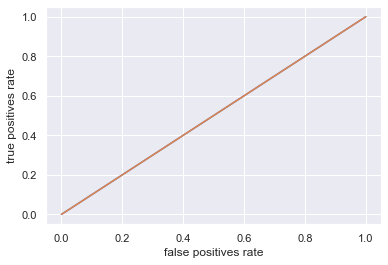

In [322]:
print("AUC from Approach 2 (Imputation):")
print(score_dataset_randomForest(imputed_X_train, imputed_X_valid, y_train, y_valid))
imputed_X_train.head()

2. Try only label columns

MAE from Approach 2 (Imputation):
0.5


,sex,anatom_site_general_challenge
22826,1,5
20292,2,2
29431,2,1
15395,1,5
2333,2,5


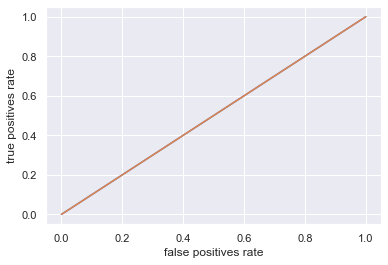

In [302]:
print("MAE from Approach 2 (Imputation):")
print(score_dataset_randomForest(label_X_train, label_X_valid, y_train, y_valid))
label_X_train.head()

### Light Gradient Boosted Machine (lightGBM)

Baseline model score
Training model. Hold on a minute to see the validation score
Validation AUC score: 0.5443775481608042
feature_importance: [23 12 13  8  7]


,num_images,age_approx,min_age,max_age,anatom_site_general_challenge
22826,54,35.0,35.0,35.0,5
20292,30,35.0,30.0,35.0,2
29431,26,45.0,45.0,45.0,1


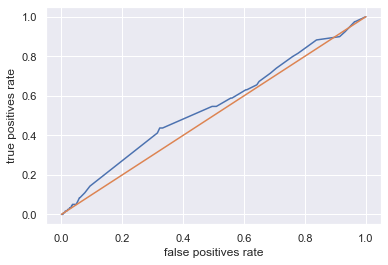

In [268]:
import lightgbm as lgb

def train_model(train, valid, y_train, y_valid, test=None, feature_cols=None):
    if feature_cols is None:
        cols_to_drop = ["num_images", "min_age","max_age", "age_span"]
        feature_cols = train.columns.drop(cols_to_drop)
    dtrain = lgb.Dataset(train[feature_cols], label=y_train)
    dvalid = lgb.Dataset(valid[feature_cols], label=y_valid)
    
    param = {'num_leaves': 64, 'objective': 'binary', 'metric': 'auc', 'seed': 42}
    num_round = 20000
    print("Training model. Hold on a minute to see the validation score")
    bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], 
                    early_stopping_rounds=40, verbose_eval=False)
    
    valid_pred = bst.predict(valid[feature_cols])
    valid_score = metrics.roc_auc_score(y_valid, valid_pred)
    print(f"Validation AUC score: {valid_score}")
    fpr, tpr, _ = metrics.roc_curve(y_valid, valid_pred, pos_label=1)
    plt.plot(fpr,tpr)
    plt.plot(fpr,fpr)
    plt.xlabel('false positives rate')
    plt.ylabel('true positives rate')
    if test is not None: 
        test_pred = bst.predict(test[feature_cols])
        test_score = metrics.roc_auc_score(test['is_attributed'], test_pred)
        return bst, valid_score, test_score
    else:
        return bst, valid_score

print("Baseline model score")
feature_cols = ["num_images","age_approx", "min_age", 
                "max_age",  "anatom_site_general_challenge"]
bst, _ = train_model(baseline_train, baseline_valid, y_train, y_valid, feature_cols=feature_cols)
print("feature_importance:",bst.feature_importance())
baseline_train[feature_cols].head(3)

Training model. Hold on a minute to see the validation score
Validation AUC score: 0.511879901799355
feature_importance: [59 28 24 30 12 17 19]


,num_images,age_approx,min_age,max_age,age_span,anatom_site_general_challenge,sex_anatom_site_general_challenge
22826,54,35.0,35.0,35.0,0.0,5,9


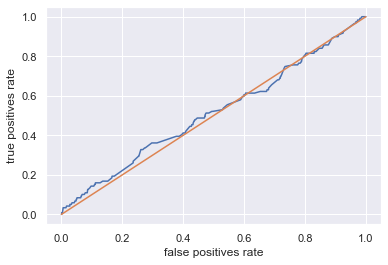

In [288]:
feature_cols = [
   'num_images',
  'age_approx',
   'min_age',
  'max_age',
    'age_span',
#   'sex',
   'anatom_site_general_challenge',
  'sex_anatom_site_general_challenge'
]
bst, _ = train_model(baseline_train, baseline_valid, y_train, y_valid, feature_cols=feature_cols)
print("feature_importance:",bst.feature_importance())
baseline_train[feature_cols].head(1)

Training model. Hold on a minute to see the validation score
Validation AUC score: 0.511879901799355
feature_importance: [59 28 24 30 12  6 17 13]


,num_images,age_approx,min_age,max_age,age_span,sex,anatom_site_general_challenge,sex_anatom_site_general_challenge
22826,54,35.0,35.0,35.0,0.0,1,5,9
20292,30,35.0,30.0,35.0,5.0,2,2,13
29431,26,45.0,45.0,45.0,0.0,2,1,12


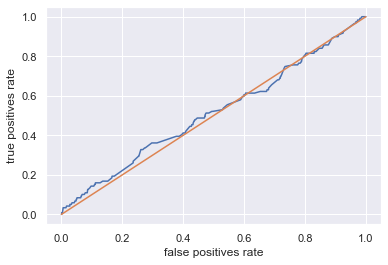

In [282]:
feature_cols = baseline_train.columns.to_list()
bst, _ = train_model(baseline_train, baseline_valid, y_train, y_valid, feature_cols=feature_cols)
print("feature_importance:",bst.feature_importance())
baseline_train[feature_cols].head(3)

## Univariate Feature Selection

The simplest and fastest methods are based on univariate statistical tests. Scikit-learn's feature selection module, `feature_selection.SelectKBest` returns the K best features given some scoring function. For our classification problem, the module provides three different scoring functions: $\chi^2$, ANOVA F-value, and the mutual information score. The F-value measures the linear dependency between the feature variable and the target (might underestimate if nonlinear). The mutual information score is nonparametric and so can capture nonlinear relationships. Using `.fit_transform(features, target)` we get back an array with only the selected features.

In [289]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Keep 5 features
selector = SelectKBest(mutual_info_classif, k=5)
#Use only train set to avoid leakage
X_new = selector.fit_transform(baseline_train, y_train)
selected_features = pd.DataFrame(selector.inverse_transform(X_new),  columns=baseline_train.columns).head()
selected_features = selected_features.columns[selected_features.var() != 0].to_list()
#baseline_train[selected_features].head(2)
selected_features

['num_images',
 'age_approx',
 'age_span',
 'sex',
 'anatom_site_general_challenge']

Training model. Hold on a minute to see the validation score
Validation AUC score: 0.5584619278785742
feature_importance: [435 313 117  79 127]


,num_images,age_approx,age_span,sex,anatom_site_general_challenge
22826,54,35.0,0.0,1,5
20292,30,35.0,5.0,2,2
29431,26,45.0,0.0,2,1


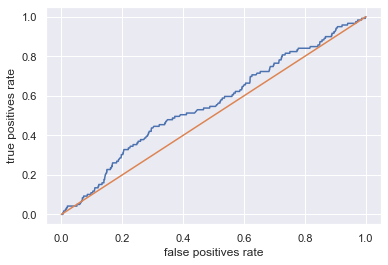

In [290]:
feature_cols = selected_features
bst, _ = train_model(baseline_train, baseline_valid, y_train, y_valid, feature_cols=feature_cols)
print("feature_importance:",bst.feature_importance())
baseline_train[feature_cols].head(3)

## Try other models

In [243]:
baseline_train['anatom_site_general_challenge'].iloc[:10]

22826    4
20292    1
29431    0
15395    4
2333     4
23787    1
15895    1
17271    4
29285    1
17599    4
Name: anatom_site_general_challenge, dtype: int64

In [253]:
X_train['anatom_site_general_challenge'].iloc[:10]

22826              torso
20292    lower extremity
29431          head/neck
15395              torso
2333               torso
23787    lower extremity
15895    lower extremity
17271              torso
29285    lower extremity
17599              torso
Name: anatom_site_general_challenge, dtype: object

AUC:0.5087


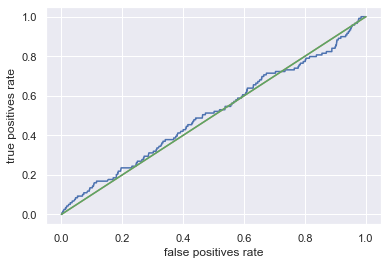

In [292]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(baseline_train[selected_features], y_train)

# Predict probability target
y_pred_p = clf.predict_proba(baseline_valid[selected_features])

fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred_p[:,1], pos_label=None)
plt.plot(fpr,tpr)
plt.plot(tpr,tpr)
plt.xlabel('false positives rate')
plt.ylabel('true positives rate')
plt.plot(fpr,fpr)
print('AUC:%s'%np.round(auc(fpr, tpr),5))

## Summary 

1. Too much data, what to do ?? Cloud, Kaggle. Encode images in cloud like env and then use encodings locally. Ignore images for the mean time and include them later on. 
2. Binary classifier
3. `image_name, patient_id, sex, age_approx, anatom_site_general_challenge, diagnosis, benign_malignant, target` Categorical variables ?? 
4. PCA o tSNE 
4. Ideas: Use ResNet to encode images, other options Inception, VGG, CV2 ?? Which??
5. Note that test set DO NOT HAVE: `diagnosis, benign_malignant, target`  and the task is to predict ` target`
6. Is there any other relevant information in the DICOM or tfrecords available in the data set. 
7. What should we use for a cost function
8. Review Notebooks on Kaggle, see below.  
9. How to work with unbalance datasets, 
10. Benchamark XGBoost... 


Reference 
* [Kaggel notebook](https://www.kaggle.com/allunia/don-t-turn-into-a-smoothie-after-the-shake-up)

## Strategy

1. Run model with only the metadata, XGBoost, logistic regresion(benchmark), categorical variables
2. f1 score, note that 
3. Feature importance -- XGBoost, shapely values
66. Encoding de las imagenes --  mole size ?????  
3. Preprocessing (mole shape) CV2 ("normalise"), 
4. Mid July EDA 
5. Agosto Run-Run-Run

## Ideas con Carlos
1. Usar features de smoothie -- Numero de imagenes por paciente, sacar mas features, benign/malign(no esta train set), 
2. Mirar imagenes: Data augmentation (positives), contornos, y color --- standarizar.
3. StratifiesKFold para solucionar low positive stats
4. See categorical variables, oridinal or not. 

# Dependencies

In [3]:
!pip install seaborn

     |████████████████████████████████| 215 kB 374 kB/s eta 0:00:01
